In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/My\ paper

/content/drive/Shareddrives/My paper


In [ ]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import seaborn as sns

In [ ]:
member = pd.read_csv('dataset/91APP_MemberData.csv')

In [ ]:
order = pd.read_csv('dataset/91APP_OrderData.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
print(len(member['MemberID'].unique()), len(order['MemberID'].unique()))

377133 235493


In [ ]:
order['TradesDateTime'] = pd.to_datetime(order['TradesDateTime'])
order = order.sort_values(by='TradesDateTime')

In [ ]:
member['RegisterDateTime'] = pd.to_datetime(member['RegisterDateTime'])
member = member.sort_values(by='RegisterDateTime')
member = member.drop_duplicates(subset=['MemberID'], keep=False)

In [ ]:
len(member)

377132

In [ ]:
label_data = pd.read_csv('./Customer Value Prediction/TABLES/Label Data.csv')

In [ ]:
memberIDs = list(label_data['MemberID'].unique())

## 加上 UID 欄位


In [ ]:
def add_uid_col(data):
  df = data.copy()
  df['uid'] = df['MemberID'].str.replace('+', '%2B')
  df['uid'] = df['uid'].str.replace('/', '%2F')
  df['uid'] = df['uid'].str.replace('=', '%3D')

  return df['uid']

In [ ]:
label_data['uid'] = add_uid_col(label_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
uids = list(label_data['uid'].unique())

In [ ]:
print(len(memberIDs), len(uids))

83931 83931


## 讀取所有行為資料

In [ ]:
behaviors = pd.read_csv('all behaviors data.csv')

In [ ]:
behaviors.columns

Index(['Unnamed: 0', 'dc', 'did', 'uid', 'DateTime', 'bh', 'uid_filled'], dtype='object')

In [ ]:
behaviors = behaviors[behaviors['uid_filled'].isin(uids)][['did', 'uid', 'DateTime', 'bh', 'uid_filled']]

In [ ]:
len(behaviors)

12879698

## event EDA

In [ ]:
last_bh = behaviors.drop_duplicates(subset=['uid_filled'], keep='last')[['uid_filled', 'DateTime']]

In [ ]:
event_df = pd.DataFrame(behaviors.groupby(by='uid_filled').size(), columns=['Events'])

In [ ]:
event_df = pd.merge(label_data, event_df, left_on='uid', right_on='uid_filled')

In [ ]:
event_df = pd.merge(event_df, last_bh, left_on='uid', right_on='uid_filled').drop(['uid_filled'], axis=1)

In [ ]:
event_df[['Events']].describe()

,Events
count,83931.000000
mean,153.455791
std,335.599696
min,1.000000
25%,18.000000
50%,59.000000
75%,160.000000
max,21062.000000


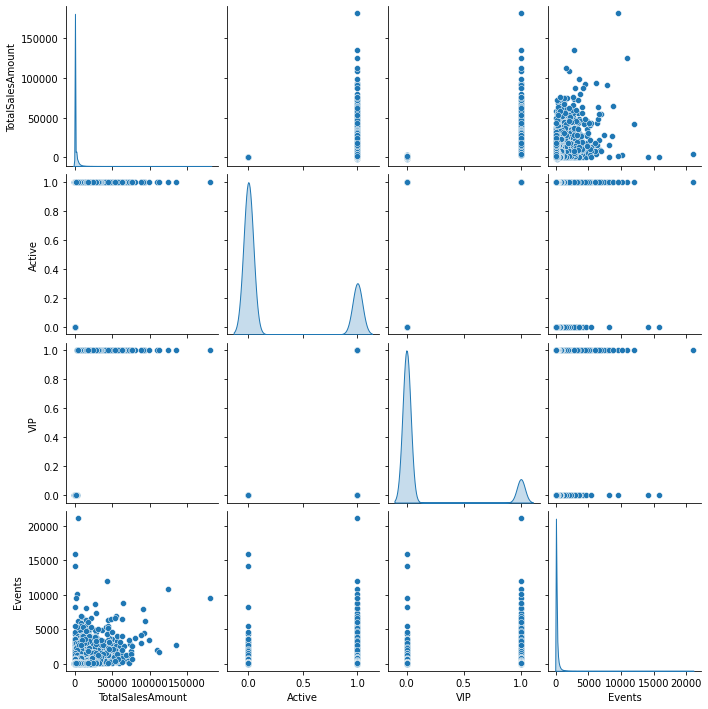

In [ ]:
sns.pairplot(event_df, diag_kind='kde')

In [ ]:
event_df.to_csv('Event Count.csv', index=False)

## Session EDA

In [ ]:
## session 切換三種狀況:
### 1. 隔天
### 2. 不同 traffic source
### 3. 閒置 30 min
def split_session(df):
  df_copy = df.copy()
  df_copy['Session'] = [0] * len(df)

  df_copy['DateTime'] = pd.to_datetime(df_copy['DateTime'], format='%Y-%m-%d %H:%M:%S')
  df_copy['datetime_previous'] = df_copy['DateTime'].shift(periods=1, fill_value=df_copy.iloc[0]['DateTime'])
  df_copy['datetime_next'] = df_copy['DateTime'].shift(periods=-1, fill_value='2020-04-30 23:59:59.999')

  df_copy['uid_pre'] = df_copy['uid_filled'].shift(periods=1, fill_value='first_member')
  df_copy['uid_next'] = df_copy['uid_filled'].shift(periods=-1, fill_value='final_member')
  df_copy.loc[(df_copy['uid_filled'] != df_copy['uid_next']), 'datetime_next'] = '2020-04-30 23:59:59.999'

  df_copy['TimeDiff'] = (df_copy['datetime_next'] - df_copy['DateTime']).astype('timedelta64[m]')
  df_copy.loc[(df_copy['uid_filled'] != df_copy['uid_next']), 'TimeDiff'] = 0
  df_copy['DayDiff'] = df_copy['DateTime'].dt.day - df_copy['datetime_previous'].dt.day
  df_copy['MinuteDiff'] = (df_copy['DateTime'] - df_copy['datetime_previous']).astype('timedelta64[m]')

  df_copy.loc[(
      (df_copy['bh'] == 'traffic') | 
      (df_copy['MinuteDiff']>=30) | 
      (df_copy['DayDiff'] != 0) | 
      (df_copy['uid_filled'] != df_copy['uid_pre'])
      ), 'Session'] = 1

  df_copy.loc[(df_copy['uid_filled'] != df_copy['uid_pre']), 'MinuteDiff'] = 0

  return df_copy

In [ ]:
split_session_data = split_session(behaviors).reset_index()
split_session_data['SessionOrder'] = split_session_data['Session'].cumsum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing <class 'str'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
session_data = pd.merge(pd.DataFrame(split_session_data.groupby(by=['uid_filled']).sum()['Session']), label_data, left_on='uid_filled', right_on='uid')

In [ ]:
session_data[['MemberID', 'Session', 'TotalSalesAmount', 'Active', 'VIP']].to_csv('Session Count.csv', index=False)

In [ ]:
session_data.describe()

,Session,TotalSalesAmount,Active,VIP
count,83931.000000,83931.000000,83931.000000,83931.000000
mean,54.933505,1097.305968,0.251421,0.133419
std,149.802898,3645.243457,0.433832,0.340029
min,1.000000,-1680.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000,0.000000
75%,43.000000,0.000000,1.000000,0.000000
max,17025.000000,181428.000000,1.000000,1.000000


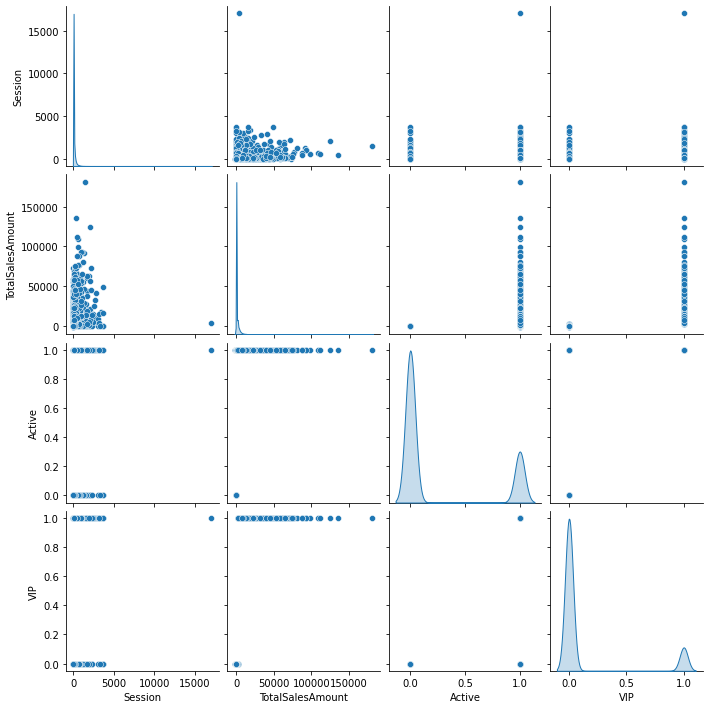

In [ ]:
sns.pairplot(session_data, diag_kind='kde')